In [18]:
# Imports
import numpy as np
import pandas as pd
import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

# Load data
url = 'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv'
data = pd.read_csv(url)

# Preprocess and standardize data
data['bmi_std'] = (data['bmi'] - data['bmi'].mean()) / data['bmi'].std()
data['age_std'] = (data['age'] - data['age'].mean()) / data['age'].std()
data['children_std'] = (data['children'] - data['children'].mean()) / data['children'].std()

# Define Stan model for multiple regression
model_code = """
data {
    int<lower=0> N;
    int<lower=0> K;
    matrix[N, K] X;
    vector[N] y;
}
parameters {
    real alpha;
    vector[K] beta;
    real<lower=0> sigma;
}
model {
    // Priors
    alpha ~ normal(0, 10);
    beta ~ normal(0, 5);
    sigma ~ inv_gamma(2, 3);

    // Likelihood
    y ~ normal(X * beta + alpha, sigma);
}
"""

# Prepare data for Stan model
stan_data = {
    'N': data.shape[0],
    'K': 3,
    'X': data[['bmi_std', 'age_std', 'children_std']].values,
    'y': data['charges'].values
}

# Compile and fit Stan model
posterior = stan.build(model_code, data=stan_data, random_seed=42)
fit = posterior.sample(num_chains=4, num_samples=1000)



Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000197 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.97 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000121 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
  Adjust your expectations accordingly!


In [19]:
# Diagnose and summarize
diagnostics = az.summary(fit)
print(diagnostics)


              mean       sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
alpha        5.356   10.080    -14.178     23.350      0.150    0.138   
beta[0]      0.245    5.006     -9.247      9.491      0.071    0.082   
beta[1]      0.297    4.893     -8.643      9.749      0.071    0.073   
beta[2]      0.063    5.138    -10.006      9.238      0.073    0.080   
sigma    17966.517  353.234  17307.358  18632.251      4.900    3.472   

         ess_bulk  ess_tail  r_hat  
alpha      4560.0    3328.0    1.0  
beta[0]    4947.0    2716.0    1.0  
beta[1]    4780.0    3448.0    1.0  
beta[2]    4953.0    3156.0    1.0  
sigma      5237.0    3091.0    1.0  


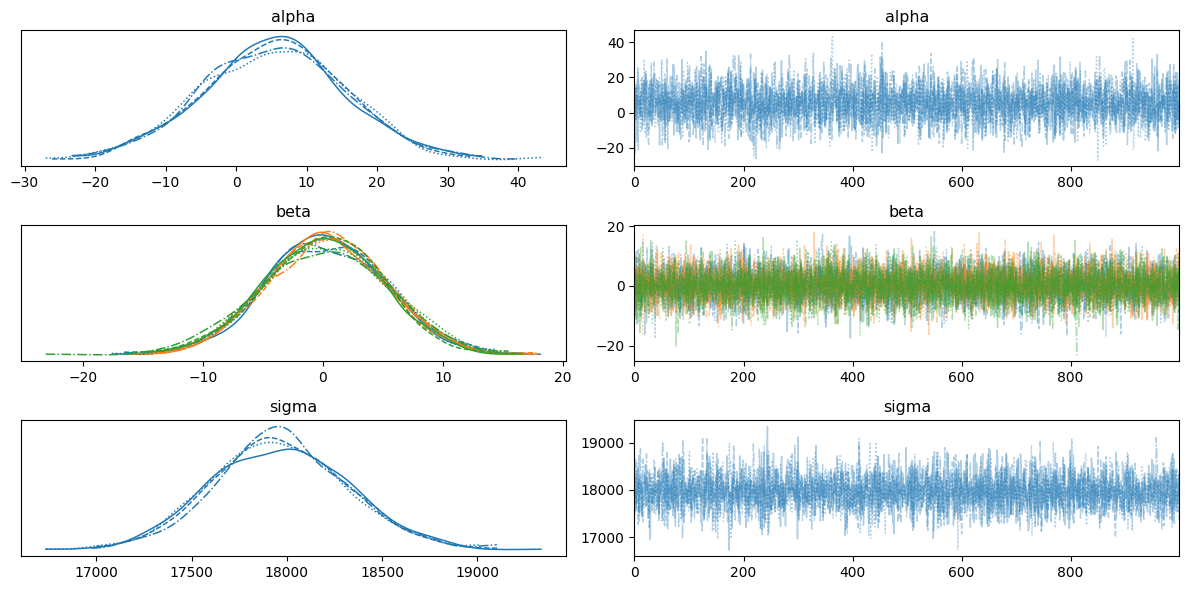

In [20]:
# Traceplots and marginals - visual convergence checks
axarr = az.plot_trace(fit)
plt.tight_layout()